# 打ち切りを含むデータから製品寿命を推定する

M. Hamada,  *et al.* "Bayesian Reliability" の寿命推定例を実装した。
- 打ち切りを含む製品寿命データから、真の寿命を推定する。  

想定している状況
- 複数の部品からなる装置を想定し、そのうち特定の部品の寿命を知りたい。
  - 社内テストではなく、実際の使用環境下での寿命を調べたい。
  - そのため、客先の装置における実例から部品寿命を推定することを考える。
- 他の部品が故障すると、対象装置の寿命前に交換されてしまう（=右側打ち切り）
  - しかも、打ち切りの期間＝他部品の寿命 であるため変動する。  
  
目的
- 打ち切り期間が変動するデータから生存時間を推定する。

## 1. ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import pickle
plt.style.use('ggplot')

## 2. データの読込・作成

"Bayesian Reliability"[1]に掲載されている軸受の寿命データを用いる

In [2]:
df = pd.read_csv('./bearing.csv', header=None)
df.rename(columns = {0:"value", 1:"trunc"}, inplace=True)

In [3]:
df[:20].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
value,1085.0,646.0,1795.0,100.0,727.0,2238.0,1500.0,820.0,1890.0,1628.0,2294.0,1388.0,1390.0,897.0,1145.0,759.0,663.0,1153.0,152.0,810.0
trunc,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
df[20:40].T

,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
value,1380.0,246.0,1427.0,2892.0,971.0,80.0,61.0,861.0,951.0,2153.0,966.0,1167.0,1165.0,462.0,767.0,853.0,997.0,711.0,437.0,1079.0
trunc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0


In [5]:
df[40:60].T

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
value,546.0,911.0,887.0,1203.0,1152.0,1199.0,736.0,2181.0,977.0,85.0,159.0,424.0,917.0,1042.0,1022.0,1070.0,3428.0,763.0,2871.0,799.0
trunc,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
df[60:].T

,60,61,62,63,64,65
value,2087.0,719.0,555.0,1297.0,1231.0,750.0
trunc,1.0,1.0,1.0,1.0,1.0,NaN


- １列目には、軸受の取付〜交換までの稼働時間が記録されている。
- ２列目には、打ち切り（この場合であれば、交換前に故障が生じていたか）の有無が記録されている。故障により交換された場合には何も記入されないが、交換時に未だ故障していなかった場合、２列目に「１」が記録される。
  - 例）index=0の軸受は1085時間が経過した時点で交換されたが、交換された時点では故障していなかった。
  - 例）index=1の軸受は646時間で破損し、すぐに交換された。

## 3. モデルの定義

原著で使用されたモデルは以下の通り

- モデル
$$f(t_u, t_{tc} | \mu, \sigma^2) = \prod_{i=1}^Nf(t_{u,i} | \mu, \sigma^2) \times \prod_{i=1}^N(1-F(t_{tc, i}|\mu, \sigma^2))$$
  ただしfは対数正規分布の確率密度関数であり、Fは累積分布関数である。  
  また$t_u$は打ち切りなしのデータ、$t_{tc}$は打ち切りありのデータを指す。

- 事前分布  
  - こちらも原著にあるものを使用した。  
  $\mu$ ∼ Normal(6.5,25)   
  $\sigma^2$∼InverseGamma(6.5,23.5)

In [7]:
stancode = """
data {
  int N_u;
  int N_tc;
  vector[N_u] X_u;
  vector[N_tc] X_tc;
  int N_new;
  vector[N_new] X_new;
}

parameters {
  real mu;
  real<lower=0> s_x;
}

model {
   mu ~ normal(6.5, 25);
   s_x ~ inv_gamma(6.5, 23.5);
  for (n_u in 1:N_u)
    X_u[n_u] ~ lognormal(mu, sqrt(s_x));
  for (n_tc in 1:N_tc) {
    target += lognormal_lccdf(X_tc[n_tc] | mu, sqrt(s_x));
  }
}

generated quantities {
  vector[N_new] lifetime;
  for (n in 1:N_new){
    lifetime[n] = exp(lognormal_lccdf(X_new[n] | mu, sqrt(s_x)));
  }
}

"""

In [8]:
# コンパイル済みのモデルがあれば読み込み。なければコンパイルし保存。
try:
    with open('./model_lifetime.pkl', "rb") as f:
        stanmodel = pickle.load(f)
except FileNotFoundError:
    stanmodel = StanModel(model_code=stancode, model_name="model_lifetime")
    with open('./model_lifetime.pkl', "wb") as f:
        pickle.dump(stanmodel, f)

## 4. 推定

### 4.1. データの整形
stan用にデータを変換する

In [9]:
df_u = df[df["trunc"] != 1] # 打ち切りなしのデータ
df_u.head()

,value,trunc
1,646,NaN
8,1890,NaN
9,1628,NaN
13,897,NaN
28,951,NaN


In [10]:
df_tc = df[df["trunc"] == 1] # 打ち切りありのデータ
df_tc.head()

,value,trunc
0,1085,1.0
2,1795,1.0
3,100,1.0
4,727,1.0
5,2238,1.0


In [11]:
standata = {"N_u":df_u.shape[0], "N_tc":df_tc.shape[0], "X_u":df_u["value"], "X_tc":df_tc["value"], 
            "N_new":17, "X_new":np.linspace(0,3000,17)}

### 4.2. MCMC実行

In [12]:
fit = stanmodel.sampling(data = standata, iter=1000, warmup=400, seed=1234)

//anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


MCMCにより得られた事後分布の概要を確認する

In [13]:
# fit.summary()をDataFrameに整形する
fit_summary = pd.DataFrame(data = fit.summary()["summary"], index = fit.summary()["summary_rownames"], 
                          columns= fit.summary()["summary_colnames"])
fit_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,8.867294,0.014367,0.418379,8.170530,8.567788,8.818797,9.121048,9.794556,848.0,1.000724
s_x,2.552790,0.030654,0.839495,1.393706,1.976292,2.382185,2.930969,4.738931,750.0,1.001302
lifetime[0],1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.0,NaN
lifetime[1],0.987904,0.000212,0.008531,0.965283,0.984513,0.990025,0.993808,0.997796,1618.0,1.000100
lifetime[2],0.966793,0.000337,0.016511,0.925100,0.958056,0.969990,0.978743,0.990159,2400.0,0.999827
lifetime[3],0.943423,0.000474,0.023225,0.887569,0.929435,0.947225,0.959962,0.978795,2400.0,0.999663
lifetime[4],0.919761,0.000594,0.029101,0.852901,0.901146,0.924013,0.940215,0.966329,2400.0,0.999595
lifetime[5],0.896572,0.000702,0.034398,0.818538,0.874375,0.901355,0.920338,0.953318,2400.0,0.999591
lifetime[6],0.874176,0.000801,0.039259,0.786193,0.849264,0.878338,0.901993,0.940028,2400.0,0.999626
lifetime[7],0.852699,0.000959,0.043762,0.756956,0.824679,0.856178,0.883870,0.927768,2081.0,0.999682


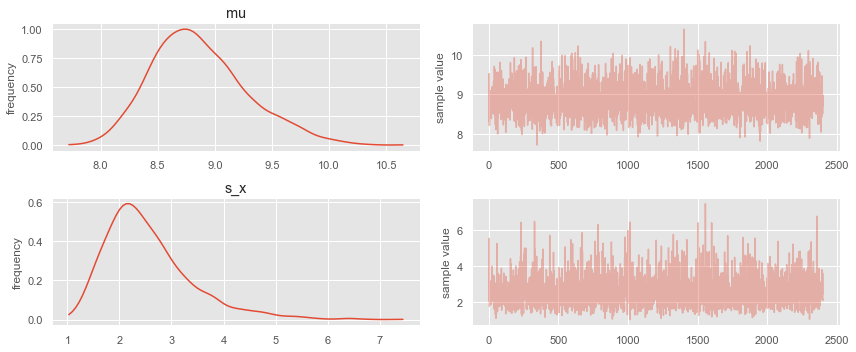

In [14]:
# 事後分布およびトレースプロットの確認
sns.set(rc={"figure.figsize":(12,5)}) # サイズの調整に必要
plt.style.use('ggplot')
fit.plot(pars=["mu", "s_x"])
plt.tight_layout()

## 5. 結果
生存関数(survival function)の90%信用区間を示す。

In [15]:
ms = fit.extract()
lifeDF = pd.DataFrame(data=ms["lifetime"], columns=standata["X_new"])

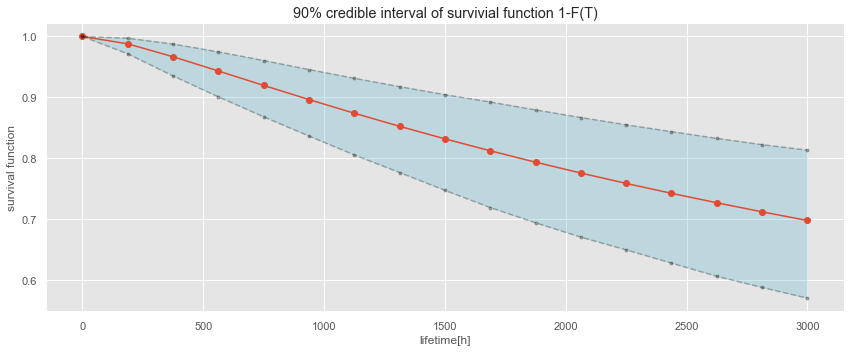

In [16]:
ax = lifeDF.mean(axis=0).plot(marker = "o")
ax = lifeDF.quantile(0.05, axis=0).plot(color="k", linestyle="--", marker = ".", alpha=0.3)
ax = lifeDF.quantile(0.95, axis=0).plot(color="k", linestyle="--", marker = ".", alpha=0.3)
ax.fill_between(standata["X_new"], lifeDF.quantile(0.05, axis=0), lifeDF.quantile(0.95, axis=0), 
                alpha=0.3, color="c1")#, interpolate=True)

ax.set_xlabel('lifetime[h]')
ax.set_ylabel('survival function')
ax.set_title('90% credible interval of survivial function 1-F(T)')
plt.tight_layout()

- この結果から、例えば90%の製品が500時間は稼働すると推定することができる。

## 参考文献
[1].  Hamada, M. S., Wilson, A., Reese, C. S., & Martz, H. (2008). Bayesian reliability. Springer Science & Business Media.